# Section 3.4 — Analytical approximation methods

This notebook contains the code examples from [Section 3.4 Analytical approximation methods]() of the **No Bullshit Guide to Statistics**.

#### Notebook setup

In [1]:
# load Python modules
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Plot helper functions
from plot_helpers import calc_prob_and_plot_tails
from plot_helpers import plot_pdf
from plot_helpers import savefigure

In [3]:
# Figures setup
plt.clf()  # needed otherwise `sns.set_theme` doesn't work
from plot_helpers import RCPARAMS
RCPARAMS.update({'figure.figsize': (10, 3)})   # good for screen
# RCPARAMS.update({'figure.figsize': (5, 1.6)})  # good for print
sns.set_theme(
    context="paper",
    style="whitegrid",
    palette="colorblind",
    rc=RCPARAMS,
)

# Useful colors
snspal = sns.color_palette()
blue, orange, purple = snspal[0], snspal[1], snspal[4]

# High-resolution please
%config InlineBackend.figure_format = 'retina'

# Where to store figures
DESTDIR = "figures/stats/NHST"

<Figure size 432x288 with 0 Axes>

In [4]:
# set random seed for repeatability
np.random.seed(42)

In [5]:
#######################################################

## Definitions

In [6]:
def mean(sample):
    return sum(sample) / len(sample)

def var(sample):
    xbar = mean(sample)
    sumsqdevs = sum([(xi-xbar)**2 for xi in sample])
    return sumsqdevs / (len(sample)-1)

def std(sample):
    s2 = var(sample)
    return np.sqrt(s2)

def dmeans(xsample, ysample):
    dhat = mean(xsample) - mean(ysample)
    return dhat

### Formulas

## Comparing one group to a theoretical model

Reminder of kombucha bottling scenario where 
theory: $K \sim \mathcal{N}(1000,10)$, samples: ⑤ kombucha

In [7]:
muK = 1000
sigmaK = 10

### Analytical approximation for sample mean

### Example 1: test for a difference in means

In [8]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch04 = kombucha[kombucha["batch"]==4]
ksample04 = batch04["volume"]
n04 = len(ksample04)

# observed mean
obsmean04 = mean(ksample04)
obsmean04

1003.8335

#### Assume we know complete model

In [9]:
from scipy.stats import norm

# standard error of the mean
se = sigmaK / np.sqrt(n04)

# compute the z statistic 
obsz = (obsmean04 - muK) / se
obsz

2.42451828205107

In [10]:
from scipy.stats import norm
rvZ = norm(0,1)
pvalue = 2 * (1 - rvZ.cdf(obsz))
pvalue

0.015328711497996528

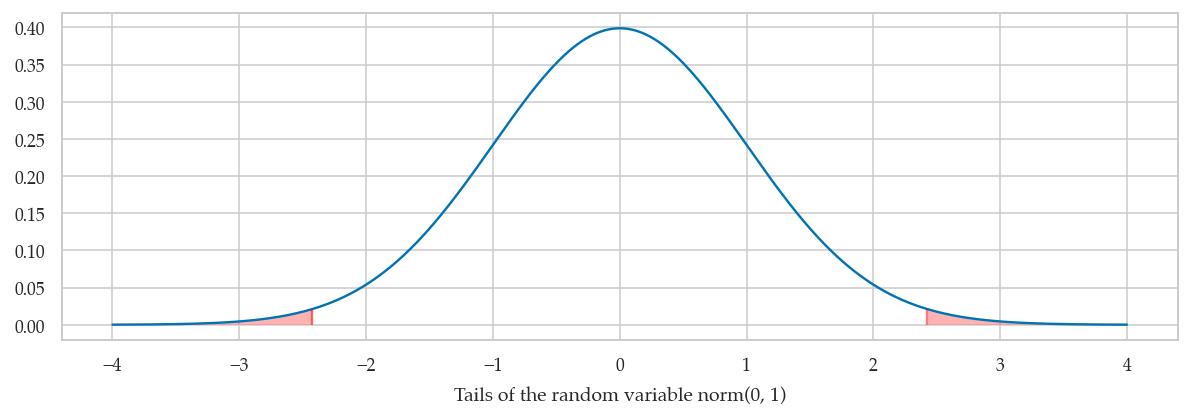

In [11]:
_ = calc_prob_and_plot_tails(rvZ, -obsz, obsz, xlims=[-4,4])

#### Assume we know mean, but not variance

In [12]:
# estimated standard error of the mean
s04 = std(ksample04)
sehat = s04 / np.sqrt(n04)

# compute the t statistic 
obst = (obsmean04 - muK) / sehat
obst

3.087703149420272

In [13]:
from scipy.stats import t as tdist

df = n04 - 1  # n-1 degrees of freedom
rvT = tdist(df)
pvalue = 2 * (1 - rvT.cdf(obst))
pvalue

0.0037056653503328985

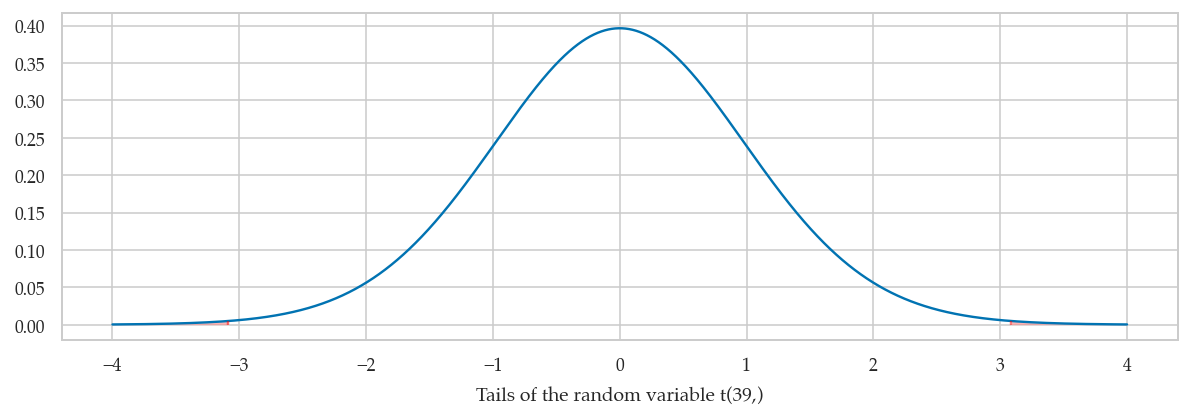

In [14]:
_ = calc_prob_and_plot_tails(rvT, -obst, obst, xlims=[-4,4])

In [15]:
# ALT. using existing function `scipy.stats`
from scipy.stats import ttest_1samp
ttest_1samp(ksample04, popmean=1000).pvalue

0.0037056653503329618

### Analytical approximation for sample variance

### Chi-square test for variance

see also:
 - https://www.itl.nist.gov/div898/handbook/eda/section3/eda358.htm
 - https://openpress.usask.ca/introtoappliedstatsforpsych/chapter/9-5-chi-squared-test-for-variance-or-standard-deviation/


### Example 2: test for a difference in variance

In [16]:
kombucha = pd.read_csv("../datasets/kombucha.csv")
batch02 = kombucha[kombucha["batch"]==2]
ksample02 = batch02["volume"]
n02 = ksample02.count()
n02

20

In [17]:
obsvar02 = var(ksample02)
obsvar02

124.31760105263136

In [18]:
obschi2 = (n02-1) * obsvar02 / sigmaK**2
obschi2

23.62034419999996

In [19]:
from scipy.stats import chi2

df = n02 - 1
rvX2 = chi2(df)

pvalue = 1 - rvX2.cdf(obschi2)
pvalue

0.2111207328360385

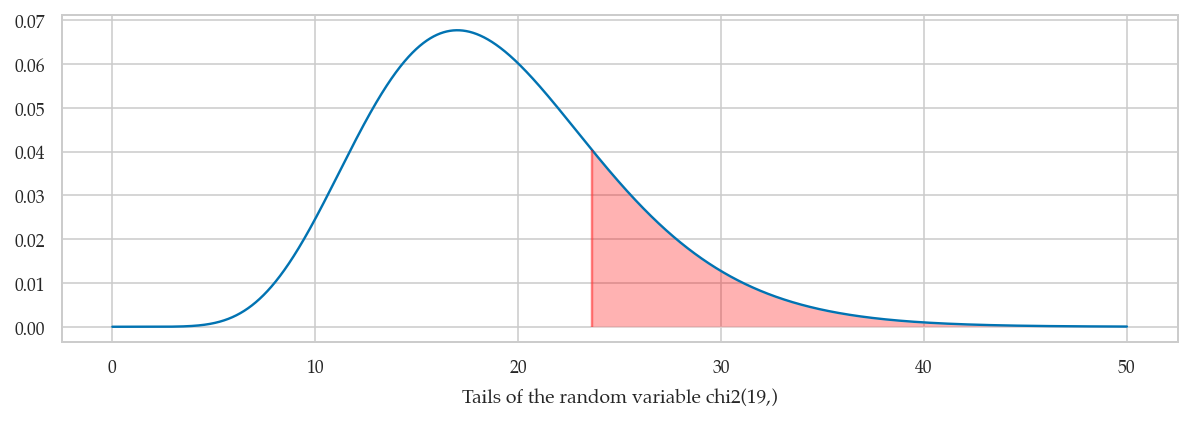

In [20]:
# plot tails
_ = calc_prob_and_plot_tails(rvX2, 0, obschi2, xlims=[0,50])

In [21]:
# TODO: ksample08


## Comparing two groups


We'll now look at another approach for answering Question 1:
using and analytical approximation,
which is the way normally taught in STATS 101 courses.
How likely or unlikely is the observed difference $d=130$ under the null hypothesis?

- Analytical approximations are math models for describing the sampling distribution under $H_0$
  - Real sampling distributions: obtained by repeated sampling from $H_0$
  - Analytical approximation: probability model based on estimated parameters
- Based on this assumption we can use the theoretical model for the difference between group means
  that we developed earlier, we can obtain a **closed form expression** for the sampling distribution of $D$.
- In particular, the probability model for the two groups under $H_0$ are:
  
  $$ 
       H_0: \qquad X_S = \mathcal{N}(\color{red}{\mu_0}, \sigma_S)
       \quad \textrm{and} \quad
       X_{NS} = \mathcal{N}(\color{red}{\mu_0}, \sigma_{NS}), \quad
  $$
  
  from which we can derive the model for $D = \overline{\mathbf{X}}_S - \overline{\mathbf{X}}_{NS}$:
  
  $$ 
     D  \sim \mathcal{N}\!\left( \color{red}{0}, \  \sqrt{ \tfrac{\sigma^2_S}{n_S} + \tfrac{\sigma^2_{NS}}{n_{NS}} } \right)
  $$
  
  In words, the sampling distribution of the difference between group means is
  normally distributed with mean $\mu_D = 0$ and standard deviation $\sigma_D$,
  which depends on the variance of the two groups $\sigma^2_S$ and $\sigma^2_{NS}$.
  Recall we obtained this expression earlier when we discussed difference of means between groups A and B.
- However, the population variances $\sigma^2_S$ and $\sigma^2_{NS}$ are unknown,
  and we only have the estimated variances $s_S^2$ and $s_{NS}^2$,
  which we calculated from the sample.
- That's OK though, since the sample variances are estimates for the population variances.
  There are two common ways to obtain an approximation for $\sigma^2_D$:
  - Unpooled variance: $\sigma^2_D \approx s^2_u = \tfrac{s^2_S}{n_S} + \tfrac{s^2_{NS}}{n_{NS}}$
    (follows from the general rule of probability theory)
  - Pooled variance: $\sigma^2_D \approx s^2_p =  \frac{(n_S-1)s_S^2 \; + \; (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$
    (takes advantage of assumption that both samples come from the same population under $H_0$)
- NEW CONCEPT: **Student's $t$-distribution** is a model for $D$ which takes into account
  we are using $s_S^2$ and $s_{NS}^2$ instead of $\sigma_S^2$ and $\sigma_{NS}^2$.
- NEW CONCEPT: **degrees of freedom**, denoted `df` in code or $\nu$ (Greek letter *nu*) in equations,
  is the parameter of Student's $t$-distribution dependent on the sample size used to estimate quantities.


### Example 3: comparing East and West electricity prices

In [22]:
eprices = pd.read_csv("../datasets/eprices.csv")
pricesW = eprices[eprices["end"]=="West"]["price"]
pricesE = eprices[eprices["end"]=="East"]["price"]

# Calculate the observed difference between means
dprices = dmeans(pricesW, pricesE)
dprices

3.0

#### Welch's t-test (unpooled variances)

We'll now show the [$t$-test](https://statkat.com/stattest.php?&t=9) procedure
known as Welch's t-test,
which allows the variances in the two groups to be different.

We'll talk about the $t$-test with pooled variances later on.

Welch's $t$-test differs only in steps 4 through 6 as shown below:

In [23]:
# Calculate the sample size and the standard deviation for each group
nW, nE = len(pricesW), len(pricesE)
stdW, stdE = std(pricesW), std(pricesE)

In [24]:
# Compute the standard error of the estimator D (Welch's t-test)
seDprices = np.sqrt(stdW**2/nW + stdE**2/nE)
seDprices

0.5972674401486561

In [25]:
def calcdf(stdX, n, stdY, m):
    vX = stdX**2 / n
    vY = stdY**2 / m
    df = (vX + vY)**2 / (vX**2/(n-1) + vY**2/(m-1))
    return df
    
# Obtain the degrees of freedom from the crazy formula
df = calcdf(stdW, nW, stdE, nE)
df

12.59281702723103

In [26]:
# Compute the value of the t-statistic
obst = (dprices - 0) / seDprices

In [27]:
from stats_helpers import tailprobs
# Calculate the p-value
rvT = tdist(df)
pvalue = tailprobs(rvT, obst, alternative="two-sided")
pvalue

0.0002570338337217614

In [28]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
result1 = ttest_ind(pricesW, pricesE, equal_var=False)
result1.pvalue

0.0002570338337217609

#### T-test with pooled variances

In [29]:
# Compute the pooled variance and standard error of estimator D
pooled_var = ((nW-1)*stdW**2 + (nE-1)*stdE**2) / (nW + nE - 2)
pooled_std = np.sqrt(pooled_var)
pooled_seDprices = pooled_std * np.sqrt(1/nW + 1/nE)

In [30]:
# Obtain the degrees of freedom
df2 = nW + nW - 2
df2

16

In [31]:
# Compute the value of the t-statistic
obst2 = (dprices - 0) / pooled_seDprices

In [32]:
from stats_helpers import tailprobs

# Calculate the p-value
rvT2 = tdist(df2)
pvalue2 = tailprobs(rvT2, obst2, alternative="two-sided")
pvalue2

0.0001249706798767125

In [33]:
# ALT. compute using existing function in `scipy.stats`
from scipy.stats import ttest_ind
result2 = ttest_ind(pricesW, pricesE, equal_var=True)
result2.pvalue

0.00012497067987678488

### Example 4: comparing rural and urban sleep scores

In [34]:
# TODO

## Explanations

### Statistical modelling assumptions

### One tailed and two-tailed hypotheses

One-sided and two-sided tests ...

Saved figure to figures/stats/NHST/panel_p-values_left_twotailed_right_tests.pdf
Saved figure to figures/stats/NHST/panel_p-values_left_twotailed_right_tests.png


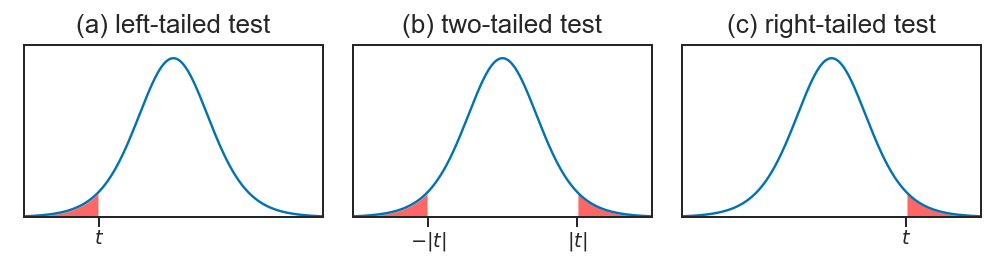

In [35]:
filename = os.path.join(DESTDIR, "panel_p-values_left_twotailed_right_tests.pdf")
    
from scipy.stats import t as tdist
rvT = tdist(9)

xs = np.linspace(-4, 4, 1000)
ys = rvT.pdf(xs)

with plt.rc_context({"figure.figsize":(7,2)}), sns.axes_style("ticks"):
    fig, (ax1, ax2, ax3) = plt.subplots(1,3)


    # LEFT
    title = '(a) left-tailed test'
    ax1.set_title(title, fontsize=13) #, y=-0.26)
    sns.lineplot(x=xs, y=ys, ax=ax1)
    ax1.set_xlim(-4, 4)
    ax1.set_ylim(0, 0.42)
    ax1.set_xticks([-2])
    ax1.set_xticklabels([])
    ax1.set_yticks([])

    # highlight the left tail
    mask = (xs < -2)
    ax1.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax1.text(-2, -0.03, r"$t$", verticalalignment="top", horizontalalignment="center")



    # TWO-TAILED
    title = '(b) two-tailed test'
    ax2.set_title(title, fontsize=13)#, y=-0.26)
    sns.lineplot(x=xs, y=ys, ax=ax2)
    ax2.set_xlim(-4, 4)
    ax2.set_ylim(0, 0.42)
    ax2.set_xticks([-2,2])
    ax2.set_xticklabels([])
    ax2.set_yticks([])

    # highlight the left and right tails
    mask = (xs < -2)
    ax2.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax2.text(-2, -0.03, r"$-|t|$", verticalalignment="top", horizontalalignment="center")
    mask = (xs > 2)
    ax2.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax2.text(2, -0.03, r"$|t|$", verticalalignment="top", horizontalalignment="center")



    # RIGHT
    title = '(c) right-tailed test'
    ax3.set_title(title, fontsize=13)#, y=-0.26)
    sns.lineplot(x=xs, y=ys, ax=ax3)
    ax3.set_xlim(-4, 4)
    ax3.set_ylim(0, 0.42)
    ax3.set_xticks([2])
    ax3.set_xticklabels([])
    ax3.set_yticks([])

    # highlight the right tail
    mask = (xs > 2)
    ax3.fill_between(xs[mask], y1=ys[mask], alpha=0.6, facecolor="red")
    ax3.text(2, -0.03, "$t$", verticalalignment="top", horizontalalignment="center")


savefigure(fig, filename)

## Discussion
### Hypothesis testing using confidence intervals
### Comparison to resampling methods
### Other statistical methods

## Exercises
## Links

# IMPORTED OLD WRITEUP

### Student's t-test (pooled variance)

[Student's $t$-test for comparison of the difference between two groups means](https://statkat.com/stattest.php?&t=9) is a procedure that makes use of the pooled variance $s^2_p$. 
Recall $H_0$ states there is no difference between the two groups.
This means we can think of $s_S^2$ and $s_{NS}^2$ as two independent estimates of the population variance,
so we can combine them (pool them together) to obtain an estimate $s^2_p$.

#### Black-box approach
The `scipy.stats` function `ttest_ind` will perform all the steps of Student's $t$-test procedure,
without the need for us to understand the details.

In [36]:
# from scipy.stats import ttest_ind

# # extract data for two groups
# xS = data[data["group"]=="S"]['ELV']
# xNS = data[data["group"]=="NS"]['ELV']

# # run the complete t-test procedure for ind-ependent samples:
# result = ttest_ind(xS, xNS)
# result.pvalue

The $p$-value is less than 0.05 so our decision is to **reject the null hypothesis**.

#### Student's t-test under the hood

The computations hidden behind the function `ttest_ind` involve a six step procedure that makes use of the pooled variance $s^2_p$.

### Summary of Question 1

We saw two ways to answer Question 1 (is there really a difference between group means) and obtain the $p$-value.
We interpreted the small $p$-values as evidence that the observed difference, $d=130$, is unlikely to be due to chance under $H_0$, so we rejected the null hypothesis.
Note this whole procedure is just a sanity check—we haven't touched the alternative hypothesis at all yet,
and for all we know the stats training could have the effect of decreasing ELV!


## Estimating the effect size

- Question 2 of Amy's statistical investigation is to estimate the difference in ELV gained by stats training.
- NEW CONCEPT: **effect size** is a measure of difference between intervention and control groups.
- We assume the data of **Group S** and **Group NS** come from different populations with means $\mu_S$ and $\mu_{NS}$.
- We're interested in estimating the difference between population means, denoted $\Delta = \mu_S - \mu_{NS}$.
- By analyzing the sample, we have obtained an estimate $d=130$ for the unknown $\Delta$,
  but we know our data contains lots of variability, so we know our estimate might be off.
- We want an answer to Question 2 (What is the estimated difference between group means?)
  that takes into account the variability of the data.
- NEW CONCEPT: **confidence interval** is a way to describe a range of values for an estimate
  that takes into account the variability of the data.
- We want to provide an answer to Question 2 in the form of a confidence interval that tells
  us a range of values where we believe the true value of $\Delta$ falls.
- Similar to how we showed two approaches for hypothesis testing,
  we'll work on effect size estimation using two approaches: bootstrap estimation and analytical approximation methods.


### Approach 2: Confidence intervals using analytical approximations

  - Assumption: the variance of the two populations is the same (or approximately equal)
  - Using the theoretical model for the populations,
    we can obtain a formula for CI of effect size $\Delta$:
    
    $$
    \textrm{CI}_{(1-\alpha)}
    = \left[ d - t^*\!\cdot\!\sigma_D, \, 
             d + t^*\!\cdot\!\sigma_D
      \right].
    $$
    
    The confidence interval is centred at $d$,
    with width proportional to the standard deviation $\sigma_D$.
    The constant $t^*$ denotes the value of the inverse CDF of Student's $t$-distribution
    with appropriate number of degrees of freedom `df` evaluated at $1-\frac{\alpha}{2}$.
    For a 90% confidence interval, we choose $\alpha=0.10$,
    which gives $(1-\frac{\alpha}{2}) = 0.95$, $t^* = F_{T_{\textrm{df}}}^{-1}\left(0.95\right)$.
  - We can use the two different analytical approximations to obtain a formula for $\sigma_D$
    just as we did in the hypothesis testing:
    - Pooled variance: $\sigma^2_p =  \frac{(n_S-1)s_S^2 + (n_{NS}-1)s_{NS}^2}{n_S + n_{NS} - 2}$,
      and `df` = $n_S + n_{NS} -2$
    - Unpooled variance: $\sigma^2_u = \tfrac{s^2_A}{n_A} + \tfrac{s^2_B}{n_B}$, and `df` = [...](https://en.wikipedia.org/wiki/Student%27s_t-test#Equal_or_unequal_sample_sizes,_unequal_variances_(sX1_%3E_2sX2_or_sX2_%3E_2sX1))

#### Using pooled variance

The calculations are similar to Student's t-test for hypothesis testing.

In [37]:
# from scipy.stats import t

# d = np.mean(xS) - np.mean(xNS)

# nS, nNS = len(xS), len(xNS)
# stdS, stdNS = stdev(xS), stdev(xNS)
# var_pooled = ((nS-1)*stdS**2 + (nNS-1)*stdNS**2)/(nS + nNS - 2)
# std_pooled = np.sqrt(var_pooled)
# std_err = std_pooled * np.sqrt(1/nS + 1/nNS)

# df = nS + nNS - 2

# # for 90% confidence interval, need 10% in tails
# alpha = 0.10

# # now use inverse-CDF of Students t-distribution
# tstar = abs(t(df).ppf(alpha/2))

# CI_tpooled = [d - tstar*std_err, d + tstar*std_err]
# CI_tpooled

#### Using unpooled variance

The calculations are similar to the Welch's t-test for hypothesis testing.

In [38]:
# d = np.mean(xS) - np.mean(xNS)

# nS, nNS = len(xS), len(xNS)
# stdS, stdNS = stdev(xS), stdev(xNS)
# stdD = np.sqrt(stdS**2/nS + stdNS**2/nNS)

# df = (stdS**2/nS + stdNS**2/nNS)**2 / \
#     ((stdS**2/nS)**2/(nS-1) + (stdNS**2/nNS)**2/(nNS-1) )

# # for 90% confidence interval, need 10% in tails
# alpha = 0.10

# # now use inverse-CDF of Students t-distribution
# tstar = abs(t(df).ppf(alpha/2))

# CI_tunpooled = [d - tstar*stdD, d + tstar*stdD]
# CI_tunpooled


## Comparison of resampling methods and analytical approximations

In this notebook we saw two different approaches for doing statistical analysis: resampling methods and analytical approximations. This is a general pattern in statistics where there is not only one correct answer: multiple approaches to data analysis are valid, and you need to think about the specifics of each situation. We'll learn about both approaches in the book.

Analytical approximations are currently taught in most stats courses (STAT 101). Historically, analytical approximations have been used more widely because they require only simple arithmetic calculations: statistic practitioners (scientists, engineers, etc.) simply need to compute sample statistics, plug them into a formula, and obtain a $p$-value. This convenience comes at the cost of numerous assumptions about the data distribution, which often don't hold in practice (e.g. assuming population is normal, when it isn't).

In recent years, resampling methods like the permutation test and bootstrap estimation are becoming more popular, widely used in industry, and increasingly also taught at universities (see this [blog post](https://minireference.com/blog/fixing-the-introductory-statistics-curriculum/) about the *modern statistics* curriculum). **The main advantage so resampling methods is that they require less modelling assumptions.** Procedures like the permutation test can be applied broadly to any scenario where two groups are being compared, and don't require developing specific formulas for different cases. Resampling methods are easier to understand since the they are directly related to the sampling distribution, and there are no formulas to memorize.

Understanding resampling methods requires some basic familiarity with programming, but the skills required are not advanced: knowledge of variables, expressions, and basic `for` loop is sufficient. If you were able to follow the code examples described above (see `resample_under_H0`, `permutation_test`, and `bootstrap_stat`), then you've already **seen all the code you will need for the entire book!**  I've prepared a [python tutorial](https://nobsstats.com/tutorials/python_tutorial.html) to make readers with no prior experience with Python will be able to quickly pick up the syntax.